In [1]:
# https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers
import torch
import torch.nn as nn
import torchtext
torchtext.disable_torchtext_deprecation_warning()
from torchtext.data.functional import generate_sp_model, load_sp_model, sentencepiece_tokenizer, sentencepiece_numericalizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.nn import functional as F
import torch.optim as optim

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import math
from torch.utils.data import Dataset, DataLoader
import torch.utils.data.dataloader as dataloader
import os
import re

In [2]:
root = "dataset"

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.	positive
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.	positive
I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.	positive

In [3]:
with open(os.path.join(root, "imdb.csv")) as f:
        with open(os.path.join(root, "data.txt"), "w") as f2:
            for line in f:
                text_only = "".join(line.split(",")[:-1])
                filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # Replaces double quotes with a space, and \n with a space
                # Replaces \\, \\n, and; with a space
                # Replaces HTML codes with real characters
                filtered = filtered.replace(' #39;', "'")
                filtered = filtered.replace(' #38;', "&")
                filtered = filtered.replace(' #36;', "$")
                filtered = filtered.replace(' #151;', "-")
                f2.write(filtered.lower() + "\n")

In [4]:
# Generate the SentencePiece tokenizer
# Text tokenizer and detokenizer
# It will tokenize words into subpieces instead of words
# This function will create a set of subtokens to fit the set vocabulary size
# There will always be enough subwords to subtokenize a dataset if you think about it :) -> max 2 length pairs = 26!
# Saved in the home directory
# generate_sp_model(os.path.join(root, "data.txt"), vocab_size=40000, model_prefix='SentencePiece/transformer')

In [5]:
# Class must inherit from Dataset to use DataLoader from torch
class IMDB(Dataset):
    def __init__(self):

        # Reads the file into a pandas DataFrame
        self.df = pd.read_csv(os.path.join(root, "imdb.csv"), names=["Article", "Class"])

        # Replaces empty entries with a space
        self.df.fillna('', inplace=True)

        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)
        self.df['Article'] = self.df['Article'].replace({' #39;': "'", ' #38;': "&", ' #36;': "$", ' #151;': "-"}, regex=True)

    # To use for DataLoader
    def __getitem__(self, index):
        text = self.df.loc[index]["Article"].lower()
        
        class_label = self.df.loc[index]["Class"]

        if class_label == 'positive':
            class_index = 1
        else:
            class_index = 0
            
        return class_index, text

    def __len__(self):
        return len(self.df)

train_dataset = IMDB()
print(len(train_dataset))
print(train_dataset.df.loc[0]["Article"])
train_dataset.df.loc[0]["Class"]

50000
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to t

'positive'

In [6]:
# Split 90% - 10%
validation_split = 0.9

# Total train examples
n_train_examples = int(len(train_dataset) * validation_split)

# Total validation examples
n_valid_examples = len(train_dataset) - n_train_examples

# Splits them based on values provided
train_data, valid_data = torch.utils.data.random_split(train_dataset, [n_train_examples, n_valid_examples], generator=torch.Generator().manual_seed(42))

In [9]:
# Create dataloaders for the training and testing datasets
# Dataloaders allow for batching, shuffling

batch_size = 128

train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)

test_loader = dataloader.DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last = True)

In [10]:
def yield_tokens(file_path):
    with io.open(file_path, encoding='utf-8') as f:
        # Iterate through each line in the file
        for line in f:
            # Accesses the vocab file, splits the line by tab, and gets the first entry (the actual token)
            # Yield the token from the first column (split by tab)
            yield [line.split("\t")[0]]

# Build a vocabulary from the tokens yielded by the yield_tokens function
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab
# From torchtext library (build_vocab_from_iterator)
# Builds a generator object, that is treated like an iterator
vocab = build_vocab_from_iterator(yield_tokens("SentencePiece/transformer.vocab"), specials=['<pad>', '<sos>', '<eos>', '<unk>'], special_first=True)

# Set the default index for unknown tokens to the index of the '<unk>' token
vocab.set_default_index(vocab['<unk>'])

In [11]:
# vocab.get_itos()

In [12]:
# Maximum sequence length for text inputs
max_len = 255

# Data transform to turn text into vocab tokens

# Takes in a list, converts to a tensor
text_transform = T.Sequential(
    # Tokeniz with pre-existing Tokenizer
    T.SentencePieceTokenizer("SentencePiece/transformer.model"),
    ## converts the sentences to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    ## Add <sos> at beginning of each sentence. 1 because the index for <sos> in vocabulary is
    # 1 as seen in previous section
    T.AddToken(vocab['<sos>'], begin=True),
    # Crop the sentance if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    ## Add <eos> at beginning of each sentence. 2 because the index for <eos> in vocabulary is
    # 2 as seen in previous section
    T.AddToken(vocab['<eos>'], begin=False),
    # Convert the list of lists to a tensor, this will also
    # Pad a sentence with the <pad> token if it is shorter than the max length
    # This ensures all sentences are the same length!
    T.ToTensor(padding_value=0),
)

In [13]:
"""
Defines a single attention head
"""

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias = False)
        self.query = nn.Linear(n_embd, head_size, bias = False)
        self.value = nn.Linear(n_embd, head_size, bias = False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x) # (B,T,C)
        q = self.query(x) # (B,T,C)
        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * C ** -0.5 # (B,T,C) @ (B,C,T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim = -1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v # (B, T, T) @ (B, T, C)
        return out

In [14]:
# Self-attention is the communication - per token level
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), 
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), 
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)


In [15]:
class Block(nn.Module):
    # Transformer followed by computation
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ffwd = FeedForward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # Residual connection
        x = x + self.ffwd(self.ln2(x))
        return x

In [16]:
"""
Defines multi-head attention, given num_heads
"""
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.dropout(self.proj(out))
        return out

In [17]:
class Transformer(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        # Each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size + 1, n_embd)
                                                    
        # self.sa_heads = MultiHeadAttention(4, n_embd//4) # Four heads, 8-dim self-attention
        # self.ffwd = FeedForward(n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head = n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, output_size)
 
    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device = device)) # (T, C)
        x = tok_emb + pos_emb # (B,T,C) -> broadcasted
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) # (B, T, output_size)

        return logits

In [18]:
# Hyperparameters
batch_size = 128 # How many independent sequences will we process in parallel?
block_size = 256 # What is the maximum context length for predictions?
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 216
n_head = 6
n_layer = 2
dropout = 0.2
nepochs = 5
output_size = 2
vocab_size = len(vocab)

In [19]:
model = Transformer()

m = model.to(device)

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

training_loss_list = []
test_loss_list = []
training_acc_list = []
test_acc_list = []

# Cosine annealing scheduler to decay the learning rate
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs, eta_min=0)

In [34]:
# Loop over each epoch
for epoch in range(nepochs):
    
    train_acc = 0
    train_steps = 0
    model.train()
    
    print("training")
    # Loop over each batch in the training dataset
    for labels, texts in train_loader:
        
        # Transform the text to tokens and move to the GPU
        text_tokens = text_transform(list(texts)).to(device)
        labels = labels.to(device)
        
        # Get the model predictions
        logits = model(text_tokens)

        # Compute the loss using cross-entropy loss
        loss = F.cross_entropy(logits[:, 0, :], labels)
        
        # Backpropagation and optimization step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
        # Log the training loss
        training_loss_list.append(loss.item())
        
        # Update training accuracy
        train_acc += (logits[:, 0, :].argmax(1) == labels).sum().item()
        train_steps += batch_size
    
    # Calculate average training accuracy
    train_acc /= train_steps
    training_acc_list.append(train_acc)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Set the model to evaluation mode
    model.eval()
    test_acc = 0
    test_steps = 0

    print("evaluating")
    # Loop over each batch in the testing dataset
    with torch.no_grad():
        for labels, texts in test_loader:
            
            # Transform the text to tokens and move to the GPU
            text_tokens = text_transform(list(texts)).to(device)
            labels = labels.to(device)
            
            # Get the model predictions
            logits = model(text_tokens)
    
            # Compute the loss using cross-entropy loss
            loss = F.cross_entropy(logits[:, 0, :], labels)
            
            # Update testing accuracy
            test_acc += (logits[:, 0, :].argmax(1) == labels).sum().item()
            test_steps += batch_size
        
        # Calculate average testing accuracy
        test_acc /= test_steps
        test_acc_list.append(test_acc)

    # Print out the results for this epoch
    print(f'Epoch {epoch+1}/{nepochs}')
    print(f'Training Accuracy: {train_acc*100:.2f}%')
    print(f'Testing Accuracy: {test_acc*100:.2f}%')

training


NameError: name 'lr_scheduler' is not defined

In [35]:
# Save the model
torch.save(model.state_dict(), 'model1337.pth')

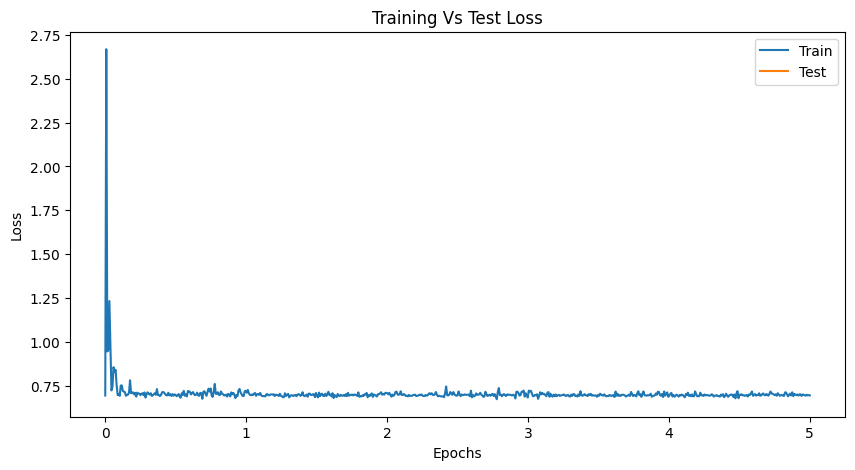

In [36]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_list)), training_loss_list)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_list)), test_loss_list)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

In [25]:
# Have to run atleast one epoch fully through
# _ = plt.figure(figsize=(10, 5))
# _ = plt.plot(np.linspace(0, nepochs, len(training_acc_list)), training_acc_list)
# _ = plt.plot(np.linspace(0, nepochs, len(test_acc_list)), test_acc_list)

# _ = plt.legend(["Train", "Test"])
# _ = plt.title("Training Vs Test Accuracy")
# _ = plt.xlabel("Epochs")
# _ = plt.ylabel("Accuracy")
# print("Max Test Accuracy %.2f%%" % (np.max(test_acc_list) * 100))

In [37]:
classes = [
    "negative",
    "positive"
]

with torch.no_grad():
    label, text = next(iter(train_loader))
    text_tokens = text_transform(list(text)).to(device)
    pred = model(text_tokens)

In [43]:
test_index = 5

# Choose a text index smaller than the total number in the batch!
assert test_index < label.shape[0]

# Select the attention map for a single sample and the first attention head
# att_map = attention_map[test_index, 0]
pred_class = classes[ pred[test_index, 0, :].argmax().item() ]
# top5 = att_map.argsort(descending=True)[:5]
# top5_tokens = vocab.lookup_tokens(text_tokens[test_index, top5].cpu().numpy())


print("Article:")
print(text[test_index])
print("\nPredicted label:")
print(pred_class)
print("True label:")
print(ag_news_classes[label[test_index].item()])
# print("\nTop 5 Tokens:")
# print(top5_tokens)

Article:
soul's midnight stars armande assante (simon) who stared in  the mambo kings  and elizabeth bennett (alicia milford). together with sexy vampire vixen, lucila sola (iris), simon lures pregnant alicia and her husband charles into the netherworld of soul's midnight. assante sinks his fangs into the script by writers brian and jason cleveland and you enjoy watching him and iris kill. alicia and charles (robert floyd) try to stay alive while gore keeps your lust for blood sated.<br /><br />(spoiler alert) in today's jaded landscape, it comes as no surprise that a back-stabbing preacher gets bitten. set looks cool  lots of detail at the borgo hotel and cool special effects at the end. i had a lot of fun watching this movie  it doesn't take itself too seriously and looks great.

Predicted label:
negative
True label:
positive
